In [1]:
import datetime as dt
import polars as pl

from model import XGBoostModel
from config import get_config

In [2]:
target_col = 'fperf'
date_col = 'tdq'

In [3]:
def find_last_trading_date():
    """
    Find last trading date, which will be used for stock selection.

    Returns
    -------
    dt.datime
        Trading date.
    """

    today = dt.datetime.today()
    trade_dates = [
        dt.datetime(today.year, 3, 1),
        dt.datetime(today.year, 6, 1),
        dt.datetime(today.year, 9, 1),
        dt.datetime(today.year, 12, 1),
    ]
    past_dates = [date for date in trade_dates if date <= today]

    if past_dates:
        return max(past_dates)
    else:
        return None

last_trade_date = find_last_trading_date()
last_trade_date

datetime.datetime(2024, 9, 1, 0, 0)

In [4]:
data = pl.read_csv("../data/1_work_data/processed/proc_2024-10-20.csv", try_parse_dates=True)
data.head()

datadate,rdq,tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,gpm,…,atr,cfm,size,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,gpm_qoq,gpm_yoy,roa_qoq,roa_yoy,roe_qoq,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_yoy,ps_yoy,freturn,adj_freturn,fperf,adj_fperf
date,date,date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
2007-01-31,2007-02-15,2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,0.578125,…,0.1758,0.072656,8.880864,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.011905,0.034773,-0.799034,-0.786032,-0.806646,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,4.036292,2.825606,-0.077548,-0.192082,15.776086,10.728947,0,1
2007-04-30,2007-05-14,2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,0.590909,…,0.182371,0.228788,8.893298,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.022113,0.058001,0.018496,-0.764364,0.041531,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,0.175701,3.789035,0.163999,-0.006303,-1.175576,2.417375,0,0
2007-07-31,2007-08-14,2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,0.590247,…,0.192074,0.128093,8.857088,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,-0.00112,-0.005011,-0.053667,-0.789586,0.011234,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,-0.007479,4.723257,0.258728,0.039965,-15.906572,-6.180591,0,0
2007-10-31,2007-11-15,2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,0.577455,…,0.198381,0.275242,8.929833,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,-0.021673,-0.01305,0.031532,-0.800194,0.068621,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,-0.053542,4.562228,0.214109,-0.015412,-1.163063,4.289494,0,0
2008-01-31,2008-02-13,2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,0.583632,…,0.185573,0.002872,8.917177,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,0.010698,0.009526,-0.074634,-0.079976,-0.028701,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.155518,-0.06733,0.019597,-0.186815,13.557644,17.149931,0,1


In [5]:
df = data.select(
    [pl.col("fperf")] + [pl.col(ratio) for ratio in get_config('model')['features']]
).to_pandas()

corr = df.corrwith(df["fperf"])
corr

fperf        1.000000
n_purch      0.015939
n_sales     -0.029266
price_mom   -0.006836
price_qoq   -0.012207
               ...   
ltcr_yoy     0.007237
pe_qoq      -0.009361
pe_yoy      -0.008864
pb_yoy      -0.014550
ps_yoy      -0.025200
Length: 69, dtype: float64

In [6]:
data = data.filter((pl.col('tdq') < last_trade_date))
data = data.filter(~pl.all_horizontal(pl.col(target_col).is_null()))

# filter cols
aux_cols = ['datadate', 'rdq', 'sector'] + [t for t in get_config('model')['targets'] if t != target_col]
data = data.select([c for c in data.columns if c not in aux_cols])
data.head()

tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,gpm,roa,roe,…,ltcr,itr,rtr,atr,cfm,size,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,gpm_qoq,gpm_yoy,roa_qoq,roa_yoy,roe_qoq,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_yoy,ps_yoy,fperf
date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,0.578125,0.088037,0.17528,…,0.037333,2.007843,1.87821,0.1758,0.072656,8.880864,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.011905,0.034773,-0.799034,-0.786032,-0.806646,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,4.036292,2.825606,-0.077548,-0.192082,0
2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,0.590909,0.089666,0.18256,…,0.173333,2.033898,1.900648,0.182371,0.228788,8.893298,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.022113,0.058001,0.018496,-0.764364,0.041531,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,0.175701,3.789035,0.163999,-0.006303,0
2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,0.590247,0.084854,0.184611,…,0.093333,2.075529,1.887363,0.192074,0.128093,8.857088,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,-0.00112,-0.005011,-0.053667,-0.789586,0.011234,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,-0.007479,4.723257,0.258728,0.039965,0
2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,0.577455,0.087529,0.197279,…,0.172017,2.1959,1.96334,0.198381,0.275242,8.929833,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,-0.021673,-0.01305,0.031532,-0.800194,0.068621,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,-0.053542,4.562228,0.214109,-0.015412,0
2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,0.583632,0.080996,0.191617,…,-0.047923,2.115414,1.906913,0.185573,0.002872,8.917177,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,0.010698,0.009526,-0.074634,-0.079976,-0.028701,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.155518,-0.06733,0.019597,-0.186815,0


In [7]:
train = data.filter(
    (pl.col('tdq').dt.year() > 2007) &
    (pl.col('tdq').dt.year() < 2020)
)
val = data.filter(
    (pl.col('tdq').dt.year() >= 2021) &
    (pl.col('tdq').dt.year() < 2023)
)


def get_scale():
    scale = int(
        len(train.filter(pl.col(target_col) == 0)) /
        len(train.filter(pl.col(target_col) == 1))
    )

    print(f"Scale of training data (pos/neg): {scale}")
    return scale

scale = get_scale()

X_train = train.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_train = train.select(target_col).to_pandas().values.ravel()
X_val = val.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_val = val.select(target_col).to_pandas().values.ravel()

X_train

Scale of training data (pos/neg): 3


,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,...,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_yoy,ps_yoy
0,0,0,0,0,0,1,0,0,0,0,...,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.283660,-0.155518,-0.067330,0.019597,-0.186815
1,0,0,0,0,0,1,0,0,0,0,...,-0.243269,0.365127,0.150162,-0.606461,-0.243443,1.671284,0.104472,-0.123835,0.000622,-0.190346
2,0,0,0,0,0,1,0,0,0,0,...,-0.061566,0.203659,0.086017,-0.624940,-0.296361,1.306055,-0.053963,-0.164869,-0.088150,-0.183973
3,0,0,0,0,0,1,0,0,0,0,...,0.077685,0.427013,0.146931,0.034227,-0.492541,-0.414559,-0.549697,-0.602664,-0.454568,-0.594871
4,0,0,0,0,0,1,0,0,0,0,...,0.227777,0.321975,0.115582,2.583585,-0.339152,0.835314,-0.137612,-0.594239,-0.475344,-0.575958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28644,0,0,0,0,0,1,0,0,0,0,...,0.350704,0.093840,0.019003,0.155060,0.027490,-0.036780,-0.010984,0.031133,0.221064,0.147269
28645,0,0,0,0,0,1,0,0,0,0,...,-0.044377,0.032798,0.006650,0.036365,0.049981,-0.261604,-0.166670,-0.288948,-0.039392,0.070703
28646,0,0,0,0,0,1,0,0,0,0,...,-0.016710,0.087359,0.018599,0.038653,0.084162,-0.231223,0.077297,-0.177863,-0.005428,0.073674
28647,0,0,0,0,0,1,0,0,0,0,...,-0.014101,0.064675,0.014194,0.018725,0.285852,-0.084477,0.260801,0.119444,0.134845,0.275905


In [8]:
model = XGBoostModel(scale=scale)
model.train(X_train, y_train)
model.evaluate(X_val, y_val)['roc_auc']

0.5920842315530802

In [9]:
model.evaluate(X_val, y_val)['prec']

0.2391304347826087

In [10]:
# pr auc analysis
baseline = float(
    len(val.filter(pl.col(target_col) == 1)) /
    len(val)
)

pr_auc = model.evaluate(X_val, y_val)['pr_auc']
pr_auc

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.1626481405803024, PR-AUC = 0.20527335294238452


In [11]:
model.get_importance("gain")

[('vol_yoy', 350.7460632324219),
 ('vol_qoq', 196.93821716308594),
 ('vol_mom', 185.46998596191406),
 ('price_2y', 167.43618774414062),
 ('price_mom', 150.3476104736328),
 ('csr', 121.79503631591797),
 ('size', 111.40265655517578),
 ('sector_Utilities', 110.74784851074219),
 ('momentum_2y', 104.15935516357422),
 ('price_yoy', 101.99102020263672),
 ('momentum_mom', 100.22334289550781),
 ('ps_yoy', 85.8071517944336),
 ('rel_vol_yoy', 82.07044982910156),
 ('rsi_30d', 75.20834350585938),
 ('ps', 74.62552642822266),
 ('qr', 71.27777099609375),
 ('momentum_yoy', 67.04034423828125),
 ('atr', 61.15639114379883),
 ('pb', 59.518348693847656),
 ('rel_vol_qoq', 56.61015319824219),
 ('sector_Energy', 54.269466400146484),
 ('rsi_90d', 50.234596252441406),
 ('gpm', 48.94585418701172),
 ('ev_eb_yoy', 45.14109420776367),
 ('ltda', 45.12582015991211),
 ('momentum_qoq', 45.012657165527344),
 ('sector_Information Technology', 44.53204345703125),
 ('rsi_1y', 38.610626220703125),
 ('dr', 38.17708969116211),

In [12]:
model.get_importance("weight")

[('vol_yoy', 29.0),
 ('size', 29.0),
 ('momentum_2y', 27.0),
 ('momentum_mom', 25.0),
 ('price_mom', 24.0),
 ('momentum_yoy', 24.0),
 ('momentum_qoq', 16.0),
 ('rel_vol_yoy', 15.0),
 ('price_2y', 14.0),
 ('csr', 14.0),
 ('ps', 13.0),
 ('vol_qoq', 12.0),
 ('price_yoy', 11.0),
 ('rsi_14d', 7.0),
 ('ps_yoy', 7.0),
 ('vol_mom', 6.0),
 ('roa', 6.0),
 ('dr', 6.0),
 ('atr', 6.0),
 ('sector_Utilities', 5.0),
 ('pb', 5.0),
 ('ev_eb_yoy', 5.0),
 ('rel_vol_qoq', 4.0),
 ('gpm', 4.0),
 ('rsi_1y', 3.0),
 ('sector_Financials', 2.0),
 ('price_qoq', 2.0),
 ('rel_vol_mom', 2.0),
 ('cr', 2.0),
 ('ltq_yoy', 2.0),
 ('gpm_yoy', 2.0),
 ('roe_yoy', 2.0),
 ('dr_yoy', 2.0),
 ('sector_Energy', 1.0),
 ('sector_Information Technology', 1.0),
 ('n_sales', 1.0),
 ('rsi_30d', 1.0),
 ('rsi_90d', 1.0),
 ('qr', 1.0),
 ('ltda', 1.0),
 ('cfm', 1.0),
 ('pe', 1.0),
 ('ev_ebitda', 1.0),
 ('saleq_2y', 1.0),
 ('cr_yoy', 1.0),
 ('ltda_yoy', 1.0)]

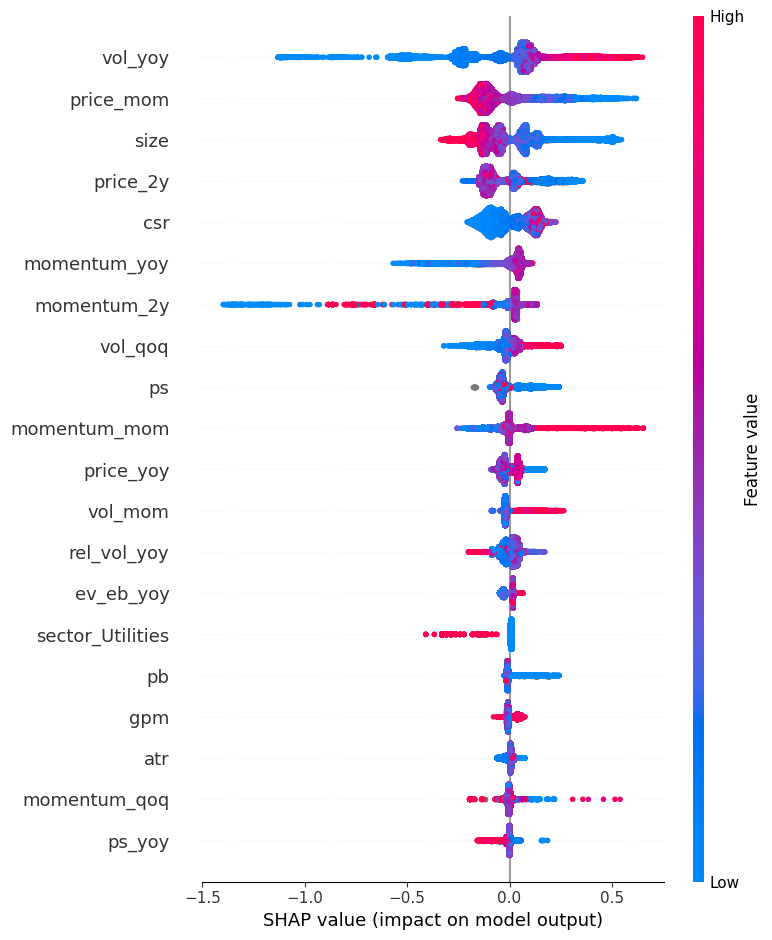

In [13]:
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=20)

In [14]:
import numpy as np
import pandas as pd

# Get mean absolute SHAP values per feature
shap_abs = pl.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': np.mean(np.abs(shap_values), axis=0)
}).sort('Mean SHAP Value', descending=False)

print(shap_abs)

shape: (79, 2)
┌───────────────────────────────┬─────────────────┐
│ Feature                       ┆ Mean SHAP Value │
│ ---                           ┆ ---             │
│ str                           ┆ f32             │
╞═══════════════════════════════╪═════════════════╡
│ sector_Communication Services ┆ 0.0             │
│ sector_Consumer Discretionary ┆ 0.0             │
│ sector_Consumer Staples       ┆ 0.0             │
│ sector_Health Care            ┆ 0.0             │
│ sector_Industrials            ┆ 0.0             │
│ …                             ┆ …               │
│ csr                           ┆ 0.090764        │
│ price_2y                      ┆ 0.107707        │
│ size                          ┆ 0.123301        │
│ price_mom                     ┆ 0.140681        │
│ vol_yoy                       ┆ 0.195131        │
└───────────────────────────────┴─────────────────┘
